In [1]:
from pycausal import *
from pycausal.inference import meta_objective, binary_causal_inference_with_interventions, ProposalSCM
from pycausal.models import MDN, GMM

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import torch

### This notebook is the recreation of the experiments and algorithms described by the paper:
(A Meta-Transfer Objective for Learning to Disentangle Causal Mechanisms) https://openreview.net/pdf?id=ryxWIgBFPS

## Defining the base model.

In [2]:
### (X^3 + X - X^2) * sin(X) 
base = SCM("Observational Source Model")
X = Variable("X",stats.norm(0,1))

y2 = sin(X) * X * (-2)

Ny = HiddenVariable("Ny",stats.norm(0,1)) 

Y = y2 + Ny << "Y"

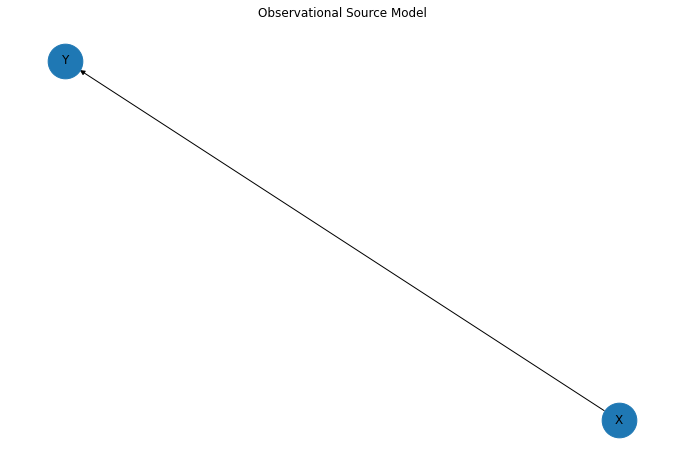

In [3]:
base.draw()

## Defining the interventions (covariance shift)

In [4]:
interv = SCM("Interventional Source Model")
iX = HiddenVariable("iX", stats.norm(0,1))
P = placeholder("P")

X = P + iX << "X"

y2 = sin(X) * X*(-2)

Ny = HiddenVariable("Ny",stats.norm(0,1))

Y = y2 + Ny << "Y"

Perturbation = HiddenVariable("Perturbation", stats.uniform(1,3))
transfer = interv.intervene({P: Perturbation})


## Samples 

In [5]:
updates=100
steps=15
episodes=100
lr = 1e-3
metalr = 1e-1
finetune=80

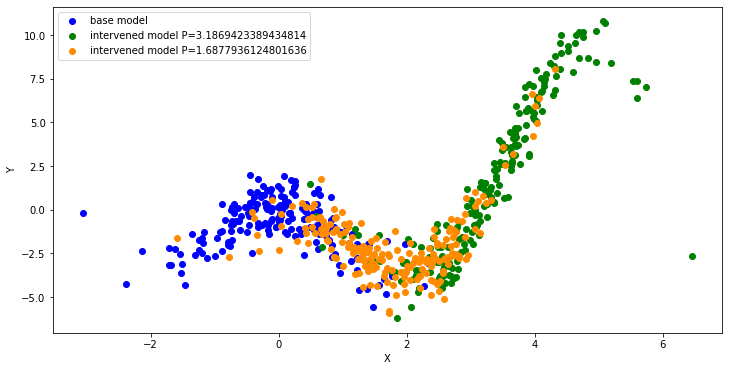

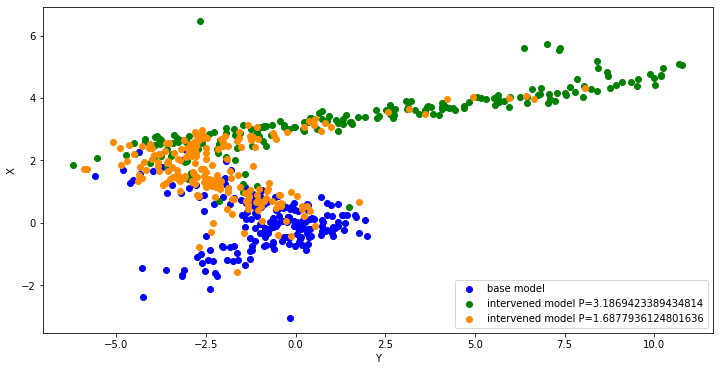

In [6]:
samples = {}
samples[base] =  base.sample(200)
samples[transfer] =  [transfer.sample(200),transfer.sample(200)]

plt.figure(figsize=(12,6))
plt.scatter( samples[base][base.nodes["X"]], samples[base][base.nodes["Y"]], label="base model", c="blue") 

p = samples[transfer][0][P][0,0].item()
plt.scatter( samples[transfer][0][X], samples[transfer][0][Y], 
            label="intervened model P="+ str(p),c="green")

p = samples[transfer][1][P][0,0].item()
plt.scatter( samples[transfer][1][X], samples[transfer][1][Y], 
            label="intervened model P="+ str(p),c="darkorange")

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


plt.figure(figsize=(12,6))
plt.scatter( samples[base][base.nodes["Y"]], samples[base][base.nodes["X"]], label="base model", c="blue") 

p = samples[transfer][0][P][0,0].item()
plt.scatter( samples[transfer][0][Y], samples[transfer][0][X], 
            label="intervened model P="+ str(p),c="green")

p = samples[transfer][1][P][0,0].item()
plt.scatter( samples[transfer][1][Y], samples[transfer][1][X], 
            label="intervened model P="+ str(p),c="darkorange")

plt.xlabel("Y")
plt.ylabel("X")
plt.legend()
plt.show()

In [7]:
#binary_causal_inference_with_interventions(
#        base, transfer, "X", "Y", epochs=250, steps=15,
#        episodes=100, lr=1e-2, metalr=0.5, finetune=30)

## An in depth look at what binary_causal_inference_with_interventions is doing

In [8]:
updates = 1000

## Learning L ( X -> Y )

In [9]:
modelxx = GMM(10)
lossxx = modelxx.fit(base, "X", loss_type="EM", entropy_reg=True, epochs=updates)
modelxy = MDN([1,36],10)
lossxy = modelxy.fit(base, "X", "Y", loss_type="EM", reg=True, epoch=updates)

## Learning L ( Y -> X )

In [10]:
modelyy = GMM(10)
lossyy = modelyy.fit(base, "Y", loss_type="EM", entropy_reg=True, epochs=updates)
modelyx = MDN([1,36],10)
lossyx = modelyx.fit(base, "Y", "X", loss_type="EM", reg=True, epoch=updates)

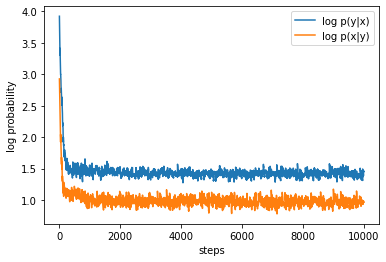

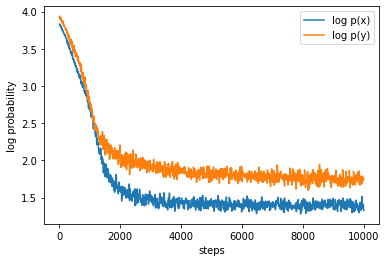

In [11]:
plt.plot(lossxy,label="log p(y|x)")
plt.plot(lossyx,label="log p(x|y)")
plt.legend()
plt.ylabel("log probability")
plt.xlabel("steps")

plt.show()

plt.plot(lossxx,label="log p(x)")
plt.plot(lossyy,label="log p(y)")
plt.legend()
plt.ylabel("log probability")
plt.xlabel("steps")

plt.show()

## learned model 

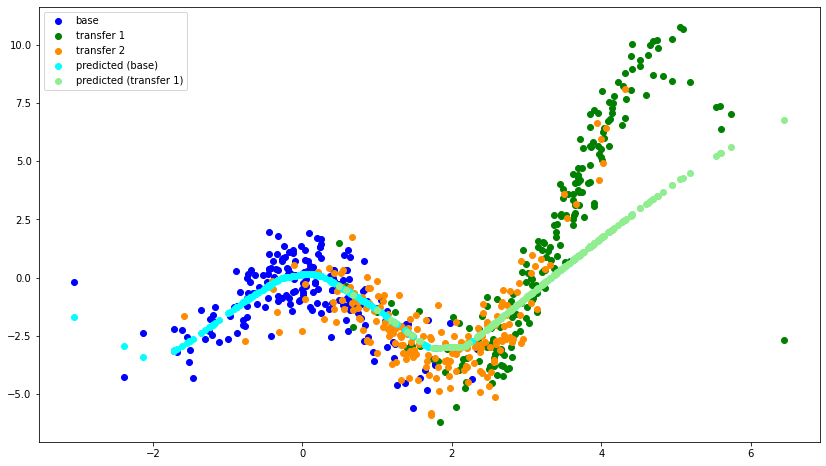

In [12]:
xx = samples[base][base.nodes["X"]]
yy =  samples[base][base.nodes["Y"]]

xx_i = samples[transfer][0][X]
yy_i =  samples[transfer][0][Y]

xx_k = samples[transfer][1][X]
yy_k =  samples[transfer][1][Y]

predxy = modelxy.predict(xx)
predxy_i = modelxy.predict(xx_i)


plt.figure(figsize=(14,8))
plt.scatter(xx,yy, label="base",c="blue")
plt.scatter(xx_i,yy_i, label="transfer 1",c="green")
plt.scatter(xx_k,yy_k, label="transfer 2",c="darkorange")
plt.scatter(xx, predxy, label="predicted (base)", c="cyan")
plt.scatter(xx_i, predxy_i, label="predicted (transfer 1)",c ="lightgreen")

plt.legend()
plt.show()

In [13]:
steps=10
finetune=40
episodes=100
lr=1e-3
metalr=1e-1

In [14]:
#torch.autograd.set_detect_anomaly(True)

tpaths = {}

scmxy = ProposalSCM(modelxx, modelxy, lr, finetune, method="MAP")
scmyx = ProposalSCM(modelyy, modelyx, lr, finetune,method="MAP")

## setup meta model.
gamma = torch.nn.parameter.Parameter(torch.zeros((1,1)))

optimizer = torch.optim.SGD(
          [ gamma ], lr=metalr, momentum=0.98)

gpath = []
lpxy = []
lpyx = []

for e in range(episodes):
    ## setup new model
    scmxy.copy()
    scmyx.copy()

    tpaths[e] = []

    ## prepare dataset
    batch = steps
    dt = transfer._sample(batch)

    X_train = dt["X"].view(-1,1)
    Y_train = dt["Y"].view(-1,1)
    
    beforexy = scmxy.online_likelihood(X_train,Y_train)
    beforeyx = scmyx.online_likelihood(Y_train,X_train)
    
    energyxy = scmxy.fit(X_train, Y_train)
    energyyx = scmyx.fit(Y_train, X_train)

    energy = energyxy - energyyx
    tpaths[e].append(energy.numpy())

    pb = gamma.sigmoid()

    pxy = scmxy.online_likelihood(X_train,Y_train)
    pyx = scmyx.online_likelihood(Y_train,X_train)
    
    
    logadxy = (beforexy - pxy).exp()
    logadyx = (beforeyx - pyx).exp()
    
    #print( "pxy" + str(pxy) )
    #print( "pyx" + str(pyx) )
    lpxy.append(logadxy )
    lpyx.append(logadyx)

    regret = - torch.log( 1e-7 + pb * logadxy + (1 - pb) * logadyx )
    #print("regret")
    #print(regret)

    optimizer.zero_grad()
    regret.backward()
    optimizer.step()

    tpaths[e] = np.stack(tpaths[e])

    gpath.append(pb.detach().numpy())

g = np.array(gpath).ravel()

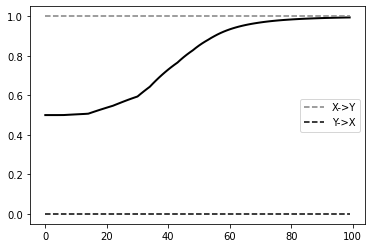

In [15]:
plt.plot(g, linewidth=2,c="black")
plt.plot(np.ones(episodes),label="X->Y",linestyle='dashed',c="grey")
plt.plot(np.zeros(episodes),label="Y->X",linestyle='dashed',c="black")
plt.legend()
plt.show()

[]

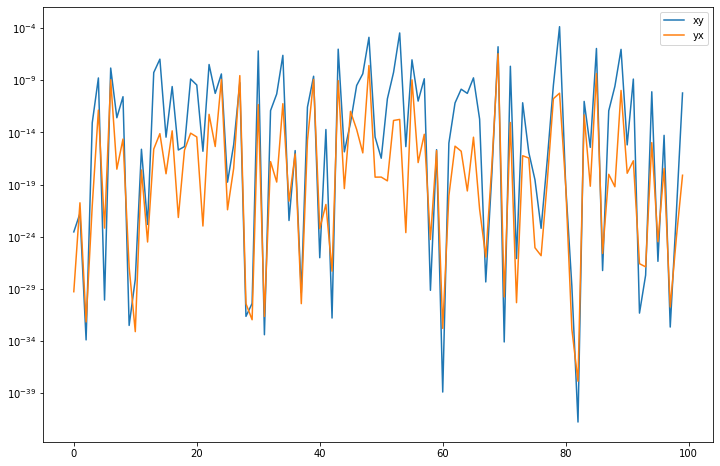

In [16]:
plt.figure(figsize=(12,8))
plt.plot(lpxy,label="xy")
plt.plot(lpyx, label="yx")
plt.yscale("log")
plt.legend()
plt.plot()

#3

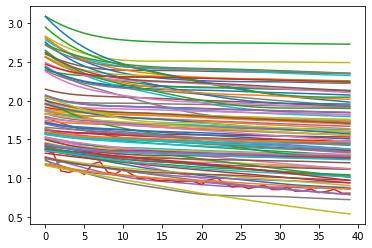

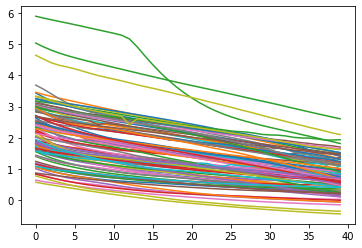

In [17]:
#plt.figure(figsize=(12,8))

plt.plot( np.array(scmxy.lftune).T)
plt.show()

#plt.figure(figsize=(12,8))

plt.plot( np.array(scmyx.lftune).T)
plt.show()

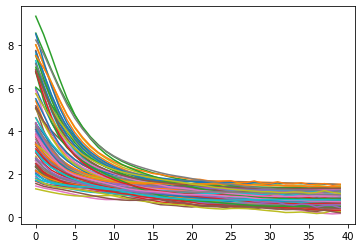

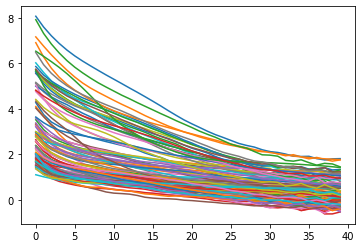

In [18]:
#plt.figure(figsize=(12,8))

plt.plot( np.array(scmxy.xlftune).T)
plt.show()

#plt.figure(figsize=(12,8))

plt.plot( np.array(scmyx.xlftune).T)
plt.show()

* the anti-causal marginal clearly needs to adapt more. 
* the causal conditonal adapts less however for some reason the anticausal conditional fits really well